# **Import the necessary libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Define the class for CNN Architecture**

In [4]:
class CNN_Architecture(nn.Module):
    def __init__(self, num_layers):
        super(CNN_Architecture, self).__init__()
        self.num_layers = num_layers
        # Same first two conv layers for all the three architectures with maxpooling after each layer
        # First conv layer: 8 filters, 11x11 kernel, stride 4, no padding
        # Maxpooling layer: 3x3 kernel, stride 2
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=11, stride=4, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

        # Second conv layer: 16 filters, 5x5 kernel, stride 1, no padding
        # Maxpooling layer: 3x3 kernel, stride 2
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

        if self.num_layers == 5:
            # Third conv layer: 32 filters, 3x3 kernel, stride 1, no padding
            # Maxpooling layer: 3x3 kernel, stride 2
            self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
            self.relu3 = nn.ReLU()
            self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

            self.fc_in_features = 32*3*3

        elif self.num_layers == 6:
            # Third conv layer: 32 filters, 3x3 kernel, stride 1, no padding
            self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
            self.relu3 = nn.ReLU()

            # Fourth conv layer: 64 filters, 3x3 kernel, stride 1, no padding
            # Maxpooling layer: 3x3 kernel, stride 2
            self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
            self.relu4 = nn.ReLU()
            self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

            self.fc_in_features = 64*2*2

        else:
            self.fc_in_features = 16*10*10

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=self.fc_in_features, out_features=128) # Adjust based on the output of conv layers
        self.relu_fc = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=128, out_features=5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        if self.num_layers == 5:
            x = self.conv3(x)
            x = self.relu3(x)
            x = self.maxpool3(x)

        elif self.num_layers == 6:
            x = self.conv3(x)
            x = self.relu3(x)
            x = self.conv4(x)
            x = self.relu4(x)
            x = self.maxpool4(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu_fc(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# **Import the dataset and reshape the images to (3, 224, 224)**

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224, preserving RGB channels
    transforms.ToTensor(), # Convert images to PyTorch tensors (C x H x W format)
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize the images
])

# Load the datasets
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/val', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/test', transform=transform)

# def compute_mean_std(dataset, batch_size):
#     loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

#     # Initialize variables to accumulate sums and counts
#     mean = np.zeros(3)
#     std = np.zeros(3)
#     total_images = 0

#     for images, _ in loader:
#         # Convert images to numpy
#         images = images.numpy()
#         # Compute mean and std for this batch
#         batch_mean = np.mean(images, axis=(0, 2, 3))
#         batch_std = np.std(images, axis=(0, 2, 3))

#         # Update total mean and std
#         mean += batch_mean * images.shape[0]
#         std += batch_std * images.shape[0]
#         total_images += images.shape[0]

#     # Average over all images
#     mean /= total_images
#     std /= total_images

#     return mean, std

# mean1, std1 = compute_mean_std(train_dataset, 32)
# mean2, std2 = compute_mean_std(val_dataset, len(val_dataset))
# mean3, std3 = compute_mean_std(test_dataset, 64)

# # Convert mean and std to lists
# mean1, mean2, mean3 = mean1.tolist(), mean2.tolist(), mean3.tolist()
# std1, std2, std3 = std1.tolist(), std2.tolist(), std3.tolist()

# # Define the normalization transform
# normalize_transform1 = transforms.Normalize(mean=mean1, std=std1)
# normalize_transform2 = transforms.Normalize(mean=mean2, std=std2)
# normalize_transform3 = transforms.Normalize(mean=mean3, std=std3)

# # Define the full transformation pipeline including normalization
# transform1 = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     normalize_transform1
# ])
# transform2 = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     normalize_transform2
# ])
# transform3 = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     normalize_transform3
# ])

# # Load the datasets again
# train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/train', transform=transform1)
# val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/val', transform=transform2)
# test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/test', transform=transform3)

# Create DataLoaders
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
len(train_dataset), len(val_dataset), len(test_dataset)

(250, 50, 100)

In [7]:
train_dataset.class_to_idx

{'butterfly': 0, 'grand_piano': 1, 'menorah': 2, 'scorpion': 3, 'starfish': 4}

# **Training and Validation function**

In [8]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs=100, patience = 10):
    best_accuracy = 0.0
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            # Clamp the outputs to prevent log(0) or NaN
            # outputs = torch.clamp(outputs, min=1e-10, max=1.0)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, pred = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (pred == labels).sum().item()

        train_acc = 100 * correct_train / total_train
        avg_train_loss = running_loss / len(train_loader.dataset)

        # Validation loop
        val_acc, val_loss = validate_model(model, val_loader, loss_fn)
        avg_val_loss = val_loss / len(val_loader.dataset)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if epoch == 0:
            # Print loss and accuracy
            print(f"Epoch [{epoch+1}/{num_epochs}]: Training Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.4f}, \n"
                  f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}\n")

        if (epoch+1) % 10 == 0:
            # Print loss and accuracy
            print(f"Epoch [{epoch+1}/{num_epochs}]: Training Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.4f}, \n"
                  f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}\n")

        # Save the best model based on validation accuracy
        if val_acc >= best_accuracy:
            best_accuracy = val_acc
            # You can save the best model if you want
            best_state = model.state_dict()

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # You can save the best model if you want
            # best_state = model.state_dict()

        else:
            epochs_no_improve += 1

        # If no improvement in validation loss for "patience" epochs, stop training
        if epochs_no_improve == patience:
            print(f"Early stopping at epoch {epoch+1}. No improvement in validation loss for {patience} epochs.\n\n")
            break

        # Step the scheduler based on validation loss
        scheduler.step(avg_val_loss)

    return train_losses, val_losses, train_accuracies, val_accuracies, best_state

def validate_model(model, val_loader, loss_fn):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            # Clamp the outputs to prevent log(0) or NaN
            # outputs = torch.clamp(outputs, min=1e-10, max=1.0)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, pred = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()

    val_acc = 100 * correct / total
    return val_acc, val_loss


# **Training the 4 later architecture(2 Conv + 2 FC) with specified hyperparameters, lr schedular and adam optimizer**

In [9]:
from torchsummary import summary
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

loss_fn = nn.CrossEntropyLoss()
print(f"\nStructure for CNN Architecture with {4} layers: \n")
model_1 = CNN_Architecture(4)
summary(model_1, input_size=(3, 224, 224))


Structure for CNN Architecture with 4 layers: 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 54, 54]           2,912
              ReLU-2            [-1, 8, 54, 54]               0
         MaxPool2d-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 22, 22]           3,216
              ReLU-5           [-1, 16, 22, 22]               0
         MaxPool2d-6           [-1, 16, 10, 10]               0
           Flatten-7                 [-1, 1600]               0
            Linear-8                  [-1, 128]         204,928
              ReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                    [-1, 5]             645
Total params: 211,701
Trainable params: 211,701
Non-trainable params: 0
----------------------------------------------

In [10]:
# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer= optim.Adam(model_1.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
print(f"\nFor CNN Architecture with {4} layers: \n")
train_loader_1 = DataLoader(train_dataset, batch_size=16, shuffle=True)
train_losses_1, val_losses_1, train_accuracies_1, val_accuracies_1, best_state1= train_model(model_1, train_loader_1, val_loader, loss_fn, optimizer, scheduler)


For CNN Architecture with 4 layers: 

Epoch [1/100]: Training Loss: 1.6082, Train Accuracy: 20.8000, 
Validation Loss: 1.6056, Validation Accuracy: 20.0000

Epoch [10/100]: Training Loss: 1.2763, Train Accuracy: 45.2000, 
Validation Loss: 1.2757, Validation Accuracy: 64.0000

Epoch [20/100]: Training Loss: 0.9682, Train Accuracy: 59.2000, 
Validation Loss: 0.9693, Validation Accuracy: 78.0000

Epoch [30/100]: Training Loss: 0.7041, Train Accuracy: 73.6000, 
Validation Loss: 0.8341, Validation Accuracy: 78.0000

Epoch [40/100]: Training Loss: 0.5568, Train Accuracy: 82.8000, 
Validation Loss: 0.7855, Validation Accuracy: 74.0000

Epoch [50/100]: Training Loss: 0.4700, Train Accuracy: 84.0000, 
Validation Loss: 0.7206, Validation Accuracy: 78.0000

Epoch [60/100]: Training Loss: 0.3547, Train Accuracy: 87.6000, 
Validation Loss: 0.6938, Validation Accuracy: 80.0000

Epoch [70/100]: Training Loss: 0.2746, Train Accuracy: 90.4000, 
Validation Loss: 0.6781, Validation Accuracy: 80.0000

Ep

# **Training the 5 later architecture(3 Conv + 2 FC)with specified hyperparameters, lr schedular and adam optimizer**

In [11]:
print(f"\nStructure for CNN Architecture with {5} layers: \n")
model_2 = CNN_Architecture(5)
summary(model_2, input_size=(3, 224, 224))


Structure for CNN Architecture with 5 layers: 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 54, 54]           2,912
              ReLU-2            [-1, 8, 54, 54]               0
         MaxPool2d-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 22, 22]           3,216
              ReLU-5           [-1, 16, 22, 22]               0
         MaxPool2d-6           [-1, 16, 10, 10]               0
            Conv2d-7             [-1, 32, 8, 8]           4,640
              ReLU-8             [-1, 32, 8, 8]               0
         MaxPool2d-9             [-1, 32, 3, 3]               0
          Flatten-10                  [-1, 288]               0
           Linear-11                  [-1, 128]          36,992
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]       

In [12]:
optimizer= optim.Adam(model_2.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
print(f"\nFor CNN Architecture with {5} layers: \n")
train_loader_2 = DataLoader(train_dataset, batch_size=16, shuffle=True)
train_losses_2, val_losses_2, train_accuracies_2, val_accuracies_2, best_state2 = train_model(model_2, train_loader_2, val_loader, loss_fn, optimizer, scheduler)


For CNN Architecture with 5 layers: 

Epoch [1/100]: Training Loss: 1.6130, Train Accuracy: 19.6000, 
Validation Loss: 1.6082, Validation Accuracy: 20.0000

Epoch [10/100]: Training Loss: 1.4821, Train Accuracy: 34.8000, 
Validation Loss: 1.4670, Validation Accuracy: 34.0000

Epoch [20/100]: Training Loss: 1.1891, Train Accuracy: 51.6000, 
Validation Loss: 1.3081, Validation Accuracy: 46.0000

Epoch [30/100]: Training Loss: 1.0703, Train Accuracy: 57.6000, 
Validation Loss: 1.2422, Validation Accuracy: 50.0000

Epoch [40/100]: Training Loss: 0.9308, Train Accuracy: 64.4000, 
Validation Loss: 1.1429, Validation Accuracy: 56.0000

Epoch [50/100]: Training Loss: 0.8309, Train Accuracy: 65.2000, 
Validation Loss: 1.0313, Validation Accuracy: 58.0000

Epoch [60/100]: Training Loss: 0.7512, Train Accuracy: 66.4000, 
Validation Loss: 0.9833, Validation Accuracy: 62.0000

Epoch [70/100]: Training Loss: 0.7037, Train Accuracy: 71.6000, 
Validation Loss: 0.9416, Validation Accuracy: 66.0000

Ep

# **Training the 6 later architecture(4 Conv + 2 FC) with specified hyperparameters, lr schedular and adam optimizer**

In [13]:
print(f"\nStructure for CNN Architecture with {6} layers: \n")
model_3 = CNN_Architecture(6)
summary(model_3, input_size=(3, 224, 224))


Structure for CNN Architecture with 6 layers: 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 54, 54]           2,912
              ReLU-2            [-1, 8, 54, 54]               0
         MaxPool2d-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 22, 22]           3,216
              ReLU-5           [-1, 16, 22, 22]               0
         MaxPool2d-6           [-1, 16, 10, 10]               0
            Conv2d-7             [-1, 32, 8, 8]           4,640
              ReLU-8             [-1, 32, 8, 8]               0
            Conv2d-9             [-1, 64, 6, 6]          18,496
             ReLU-10             [-1, 64, 6, 6]               0
        MaxPool2d-11             [-1, 64, 2, 2]               0
          Flatten-12                  [-1, 256]               0
           Linear-13                  [-1, 128]       

In [14]:
optimizer= optim.Adam(model_3.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
print(f"\nFor CNN Architecture with {6} layers: \n")
train_loader_3 = DataLoader(train_dataset, batch_size=16, shuffle=True)
train_losses_3, val_losses_3, train_accuracies_3, val_accuracies_3, best_state3 = train_model(model_3, train_loader_3, val_loader, loss_fn, optimizer, scheduler)


For CNN Architecture with 6 layers: 

Epoch [1/100]: Training Loss: 1.6100, Train Accuracy: 19.2000, 
Validation Loss: 1.6101, Validation Accuracy: 20.0000

Epoch [10/100]: Training Loss: 1.4942, Train Accuracy: 38.8000, 
Validation Loss: 1.4732, Validation Accuracy: 34.0000

Epoch [20/100]: Training Loss: 1.1460, Train Accuracy: 49.2000, 
Validation Loss: 1.3059, Validation Accuracy: 48.0000

Epoch [30/100]: Training Loss: 1.0610, Train Accuracy: 50.0000, 
Validation Loss: 1.1554, Validation Accuracy: 62.0000

Epoch [40/100]: Training Loss: 0.9249, Train Accuracy: 62.0000, 
Validation Loss: 1.2339, Validation Accuracy: 52.0000

Epoch [50/100]: Training Loss: 0.8676, Train Accuracy: 61.6000, 
Validation Loss: 1.1146, Validation Accuracy: 58.0000

Epoch [60/100]: Training Loss: 0.7970, Train Accuracy: 68.8000, 
Validation Loss: 1.1162, Validation Accuracy: 58.0000

Epoch [70/100]: Training Loss: 0.7074, Train Accuracy: 70.8000, 
Validation Loss: 0.9350, Validation Accuracy: 58.0000

Ep

# **Function for Confusion Matrix for any dataset**

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, dataloader, class_names, best_state):
    all_preds = []
    all_labels = []
    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


# **Plotting the following for 4 layer architecture:**


1.   **Training and Validation Accuracies vs epochs**
2.   **Training and Validation Losses vs epochs**
3.   **Training and Validation Confusion Matrix at the best state**


Structure for CNN Architecture with 4 layers: 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 54, 54]           2,912
              ReLU-2            [-1, 8, 54, 54]               0
         MaxPool2d-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 22, 22]           3,216
              ReLU-5           [-1, 16, 22, 22]               0
         MaxPool2d-6           [-1, 16, 10, 10]               0
           Flatten-7                 [-1, 1600]               0
            Linear-8                  [-1, 128]         204,928
              ReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                    [-1, 5]             645
Total params: 211,701
Trainable params: 211,701
Non-trainable params: 0
----------------------------------------------

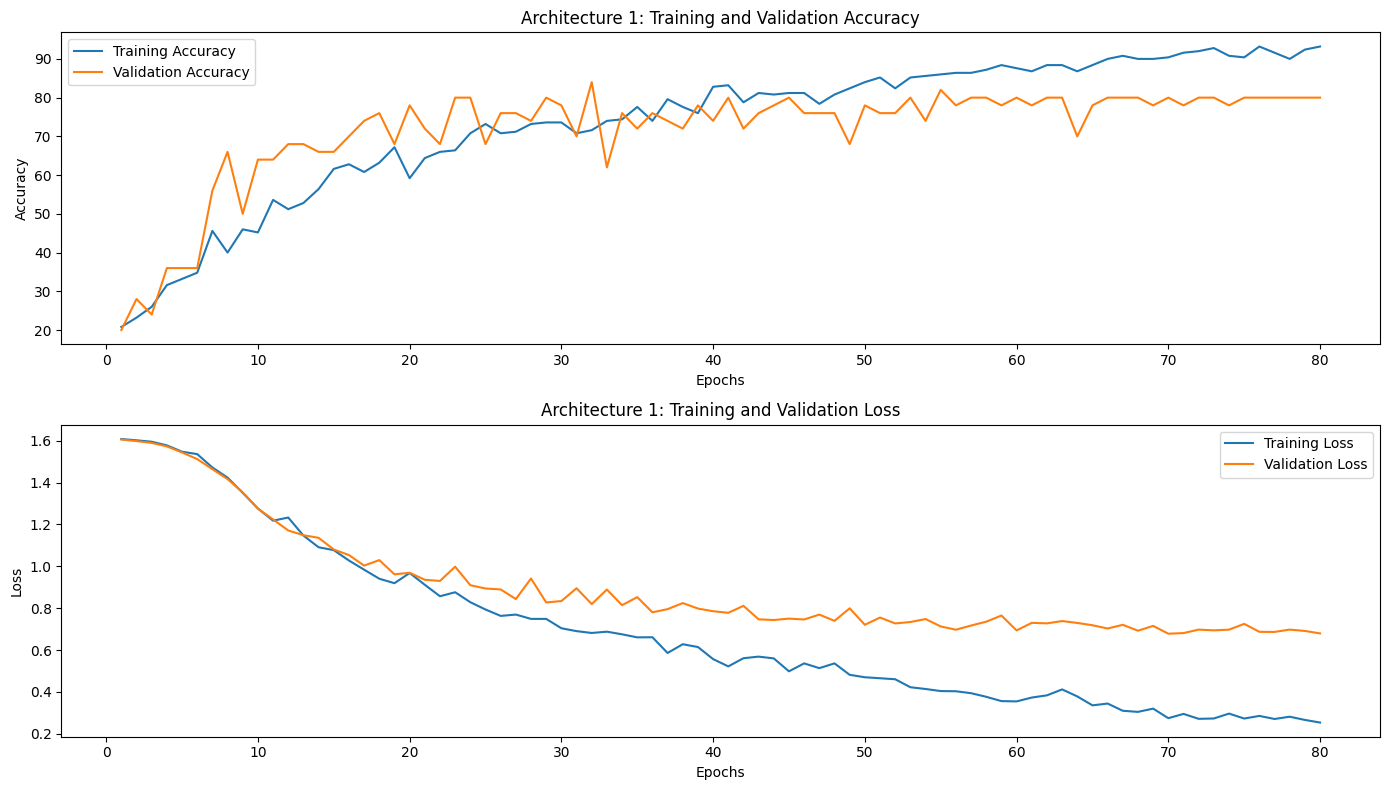

In [16]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accuracies_1) + 1)

plt.figure(figsize=(14, 8))

# Architecture 1
print(f"\nStructure for CNN Architecture with {4} layers: \n")
summary(model_1, input_size=(3, 224, 224))

plt.subplot(2, 1, 1)
plt.plot(epochs, train_accuracies_1, label='Training Accuracy')
plt.plot(epochs, val_accuracies_1, label='Validation Accuracy')
plt.title('Architecture 1: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, train_losses_1, label='Training Loss')
plt.plot(epochs, val_losses_1, label='Validation Loss')
plt.title('Architecture 1: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

For Training dataset of Model 1:



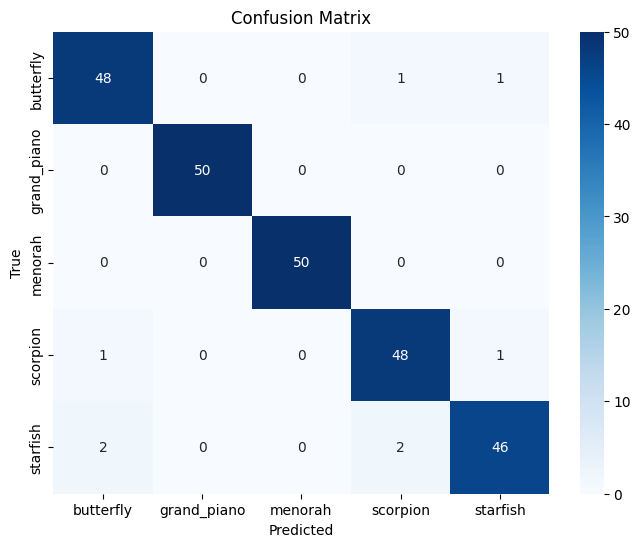

For Validation dataset of Model 1:



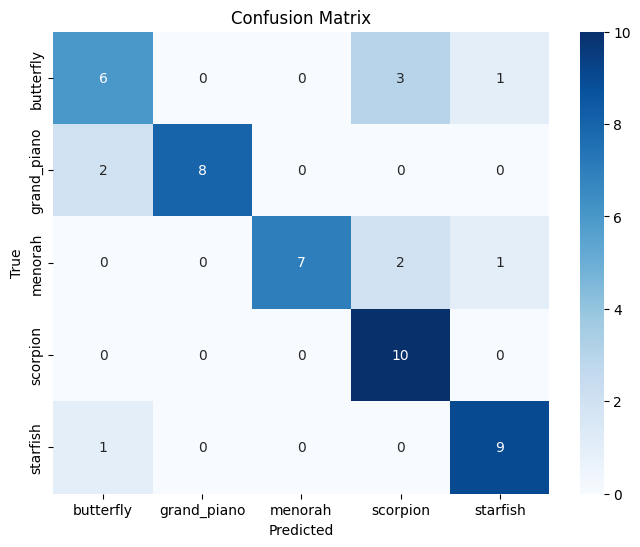

In [17]:
print("For Training dataset of Model 1:\n")
plot_confusion_matrix(model_1, train_loader_1, train_dataset.classes, best_state1)

print("For Validation dataset of Model 1:\n")
plot_confusion_matrix(model_1, val_loader, val_dataset.classes, best_state1)

# **Plotting the following for 5 layer architecture:**


1.   **Training and Validation Accuracies vs epochs**
2.   **Training and Validation Losses vs epochs**
3.   **Training and Validation Confusion Matrix at the best state**


Structure for CNN Architecture with 5 layers: 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 54, 54]           2,912
              ReLU-2            [-1, 8, 54, 54]               0
         MaxPool2d-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 22, 22]           3,216
              ReLU-5           [-1, 16, 22, 22]               0
         MaxPool2d-6           [-1, 16, 10, 10]               0
            Conv2d-7             [-1, 32, 8, 8]           4,640
              ReLU-8             [-1, 32, 8, 8]               0
         MaxPool2d-9             [-1, 32, 3, 3]               0
          Flatten-10                  [-1, 288]               0
           Linear-11                  [-1, 128]          36,992
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]       

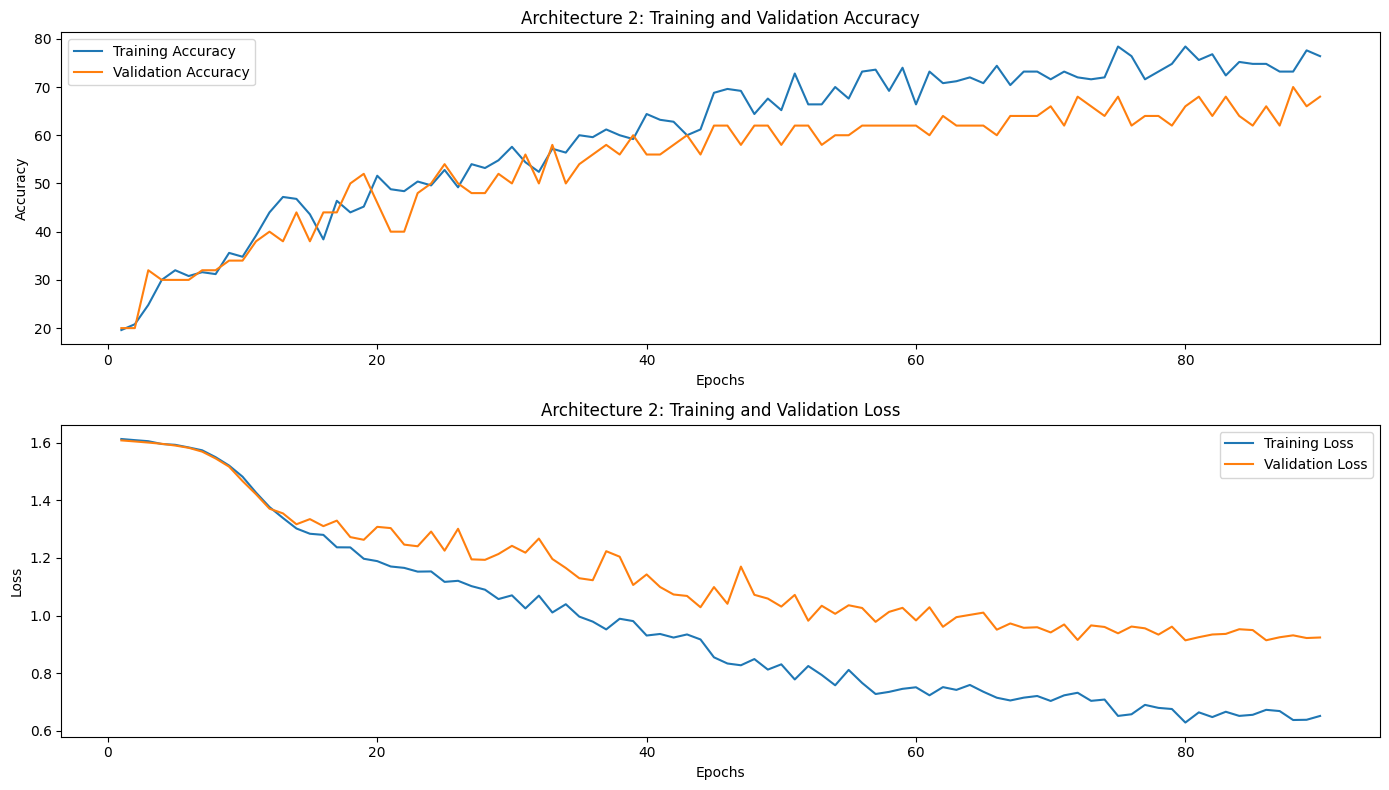

In [18]:
plt.figure(figsize=(14, 8))
epochs = range(1, len(train_accuracies_2) + 1)

# Architecture 2
print(f"\nStructure for CNN Architecture with {5} layers: \n")
summary(model_2, input_size=(3, 224, 224))

plt.subplot(2, 1, 1)
plt.plot(epochs, train_accuracies_2, label='Training Accuracy')
plt.plot(epochs, val_accuracies_2, label='Validation Accuracy')
plt.title('Architecture 2: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, train_losses_2, label='Training Loss')
plt.plot(epochs, val_losses_2, label='Validation Loss')
plt.title('Architecture 2: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

For Training dataset of Model 2:



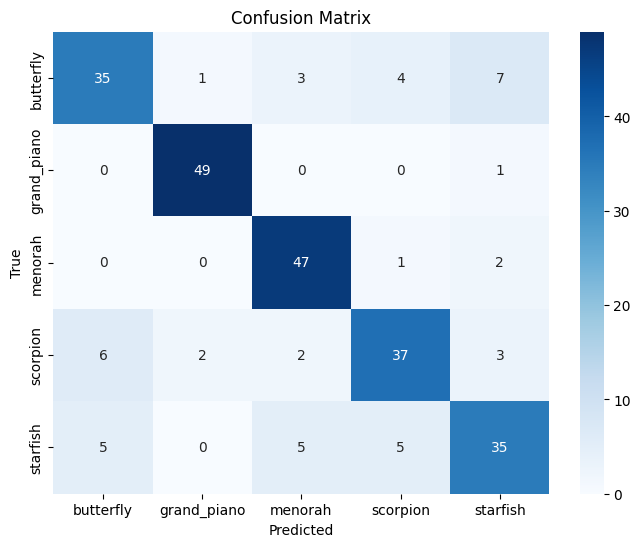

For Validation dataset of Model 2:



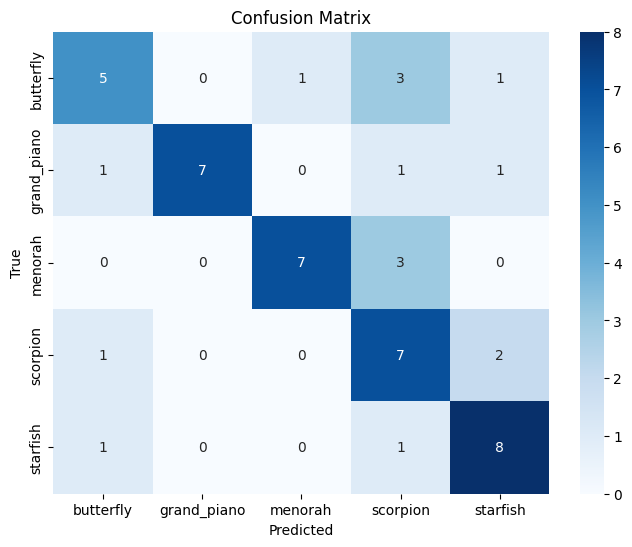

In [19]:
print("For Training dataset of Model 2:\n")
plot_confusion_matrix(model_2, train_loader_2, train_dataset.classes, best_state2)

print("For Validation dataset of Model 2:\n")
plot_confusion_matrix(model_2, val_loader, val_dataset.classes, best_state2)

# **Plotting the following for 6 layer architecture:**


1.   **Training and Validation Accuracies vs epochs**
2.   **Training and Validation Losses vs epochs**
3.   **Training and Validation Confusion Matrix at the best state**


Structure for CNN Architecture with 6 layers: 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 54, 54]           2,912
              ReLU-2            [-1, 8, 54, 54]               0
         MaxPool2d-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 22, 22]           3,216
              ReLU-5           [-1, 16, 22, 22]               0
         MaxPool2d-6           [-1, 16, 10, 10]               0
            Conv2d-7             [-1, 32, 8, 8]           4,640
              ReLU-8             [-1, 32, 8, 8]               0
            Conv2d-9             [-1, 64, 6, 6]          18,496
             ReLU-10             [-1, 64, 6, 6]               0
        MaxPool2d-11             [-1, 64, 2, 2]               0
          Flatten-12                  [-1, 256]               0
           Linear-13                  [-1, 128]       

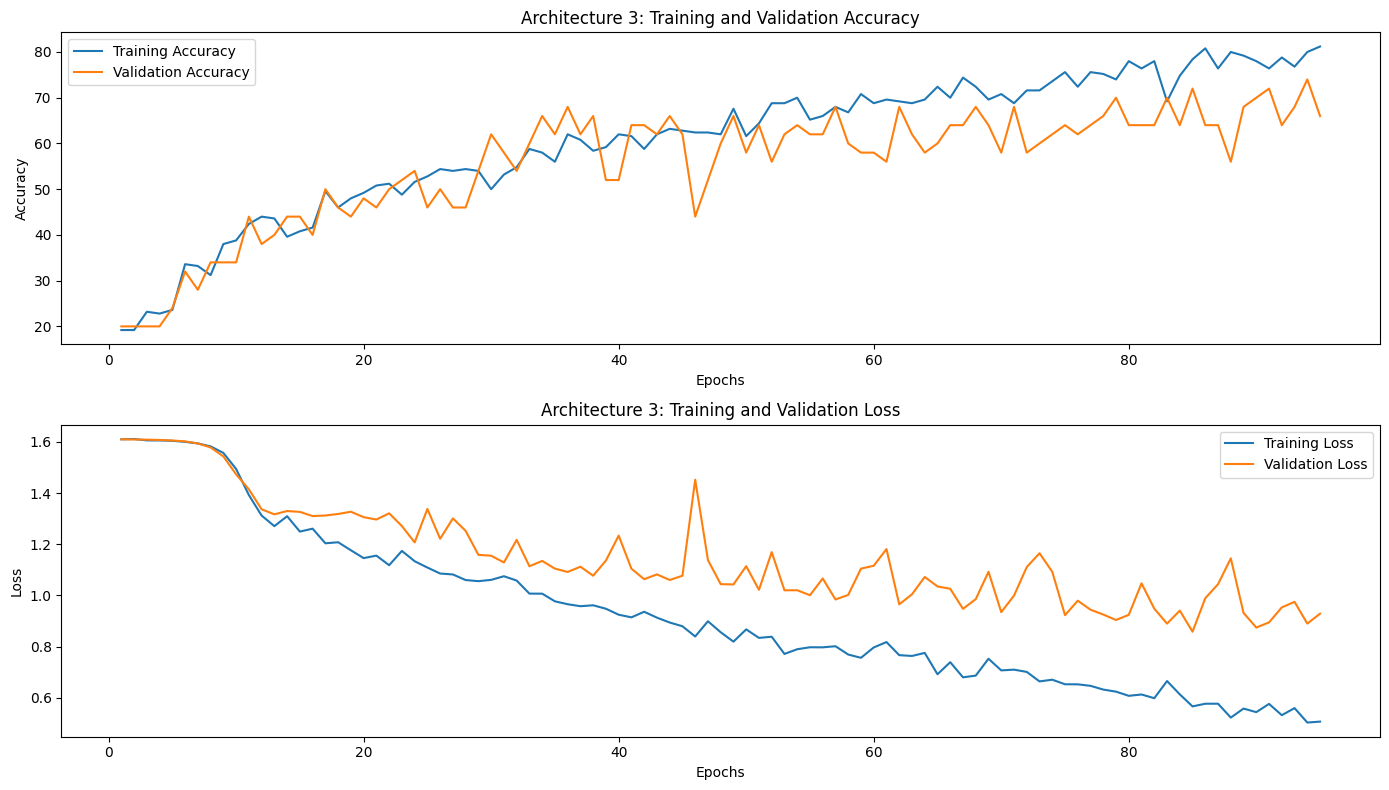

In [20]:
plt.figure(figsize=(14, 8))
epochs = range(1, len(train_accuracies_3) + 1)
# Architecture 3
print(f"\nStructure for CNN Architecture with {6} layers: \n")
summary(model_3, input_size=(3, 224, 224))

plt.subplot(2, 1, 1)
plt.plot(epochs, train_accuracies_3, label='Training Accuracy')
plt.plot(epochs, val_accuracies_3, label='Validation Accuracy')
plt.title('Architecture 3: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, train_losses_3, label='Training Loss')
plt.plot(epochs, val_losses_3, label='Validation Loss')
plt.title('Architecture 3: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

For Training dataset of Model 3:



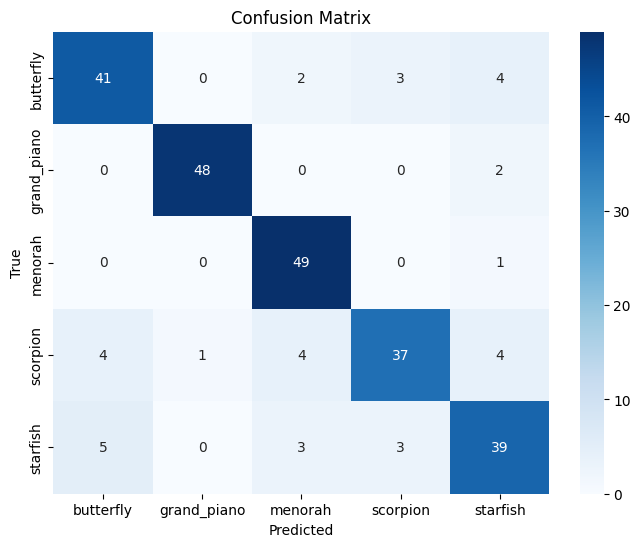

For Validation dataset of Model 3:



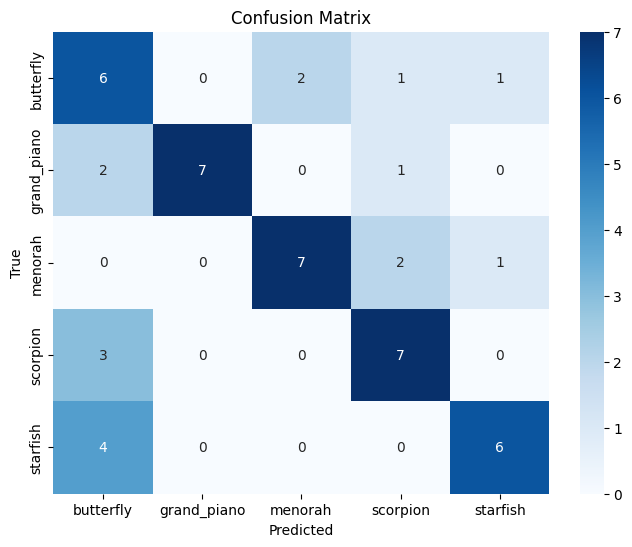

In [21]:
print("For Training dataset of Model 3:\n")
plot_confusion_matrix(model_3, train_loader_3, train_dataset.classes, best_state3)

print("For Validation dataset of Model 3:\n")
plot_confusion_matrix(model_3, val_loader, val_dataset.classes, best_state3)

# **Find the Best Architecture based on the Maximum Validation Accuracy**

In [22]:
# Compare the validation accuracies after training
print(f"Architecture 1 Validation Accuracy: {max(val_accuracies_1)}")
print(f"Architecture 2 Validation Accuracy: {max(val_accuracies_2)}")
print(f"Architecture 3 Validation Accuracy: {max(val_accuracies_3)}")

# Choose the best architecture based on highest validation accuracy
best_architecture = None
best_val_accuracy = 0

if max(val_accuracies_1) > best_val_accuracy:
    best_val_accuracy = max(val_accuracies_1)
    best_architecture = model_1
    best_state = best_state1

if max(val_accuracies_2) > best_val_accuracy:
    best_val_accuracy = max(val_accuracies_2)
    best_architecture = model_2
    best_state = best_state2
if max(val_accuracies_3) > best_val_accuracy:
    best_val_accuracy = max(val_accuracies_3)
    best_architecture = model_3
    best_state = best_state3

print(f"The best architecture is with {best_architecture.num_layers} layers, with validation accuracy: {best_val_accuracy:.2f}%")

Architecture 1 Validation Accuracy: 84.0
Architecture 2 Validation Accuracy: 70.0
Architecture 3 Validation Accuracy: 74.0
The best architecture is with 4 layers, with validation accuracy: 84.00%


# **Test Accuracy and Loss for the best model architecture along with the Confusion Matrix**

In [23]:
def test_model(model, test_loader, best_state):
    # model.load_state_dict(best_state)
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            # Clamp the outputs to prevent log(0) or NaN
            # outputs = torch.clamp(outputs, min=1e-10, max=1.0)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, pred = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()

    test_acc = 100 * correct / total
    test_loss = test_loss / len(test_loader.dataset)
    return test_acc, test_loss

test_acc, test_loss = test_model(best_architecture, test_loader, best_state)
print(f"For best architecture with {best_architecture.num_layers}: Test Accuracy: {test_acc:.4f}%, Test Loss: {test_loss:.4f}")

For best architecture with 4: Test Accuracy: 79.0000%, Test Loss: 0.6133


For Test dataset of Best Architectur Model:



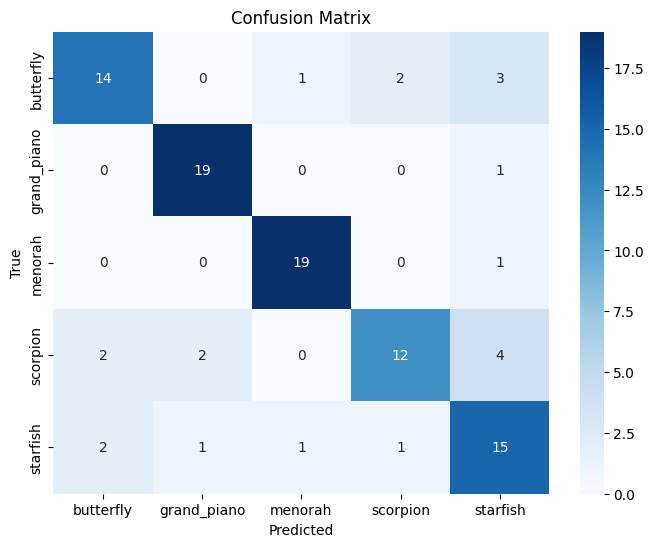

In [24]:
print("For Test dataset of Best Architectur Model:\n")
plot_confusion_matrix(best_architecture, test_loader, test_dataset.classes, best_state)

# **Plot all 8 feature maps from the first convolutional layers and a selected 8 feature maps from the remaining convolutional layers of the best architecture.**



In [25]:
def output_per_layer(model, x):
    model.eval()
    outputs = {}
    layer_info = {}
    for name, layer in model.named_children():
        if name=='flatten':
            break

        # Else forward
        x = layer(x)
        x.shape
        outputs[name] = x.detach().numpy()

        if hasattr(layer, 'kernel_size'):
            layer_info[name] = {'kernel_size': np.array(layer.kernel_size), 'stride': layer.stride}

    return outputs, layer_info

# Function to plot feature maps
def plot_feature_maps(image, feature_maps, layer_name, num_maps=8):
    fig, axes = plt.subplots(1, num_maps, figsize=(15, 15))

    # Plot feature maps
    for i in range(num_maps):
        axes[i].imshow(feature_maps[0, i], cmap='cividis')
        axes[i].set_title(f'{layer_name} - Map {i+1}')
        axes[i].axis('off')

    plt.show()

In [26]:
# Print names and modules
for name, module in best_architecture.named_children():
    print(f"Name: {name}, Module: {module}")

Name: conv1, Module: Conv2d(3, 8, kernel_size=(11, 11), stride=(4, 4))
Name: relu1, Module: ReLU()
Name: maxpool1, Module: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
Name: conv2, Module: Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
Name: relu2, Module: ReLU()
Name: maxpool2, Module: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
Name: flatten, Module: Flatten(start_dim=1, end_dim=-1)
Name: fc1, Module: Linear(in_features=1600, out_features=128, bias=True)
Name: relu_fc, Module: ReLU()
Name: dropout, Module: Dropout(p=0.5, inplace=False)
Name: fc2, Module: Linear(in_features=128, out_features=5, bias=True)


# **Consider one image from the training set (from any class).**

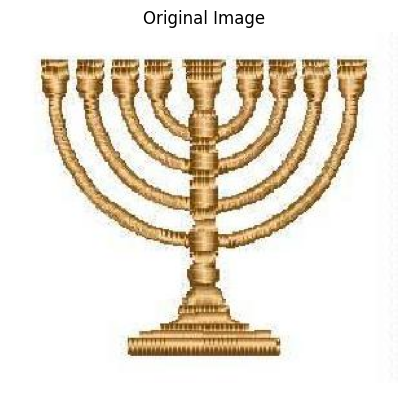

In [27]:
from PIL import Image

# Load and preprocess the image
image = Image.open('/content/drive/MyDrive/train/menorah/image_0005.jpg').convert('RGB')
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

In [28]:
# Get feature maps from the model
outputs, _= output_per_layer(best_architecture, image_tensor)
_['conv2']


{'kernel_size': array([5, 5]), 'stride': (1, 1)}

# **Plot all 8 feature maps from the first convolutional layers and a selected 8 feature maps from the remaining convolutional layers of the best architecture**

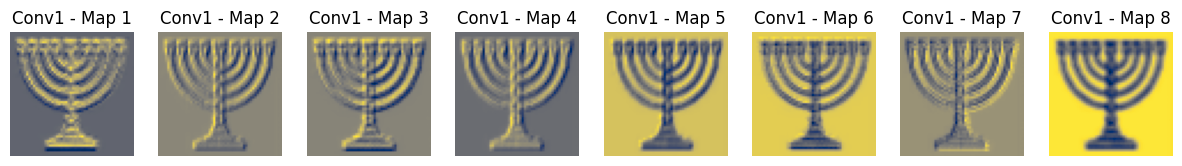

In [29]:
# Get feature maps from the model
outputs, _= output_per_layer(best_architecture, image_tensor)

# Plot feature maps from the first and second conv layers
plot_feature_maps(image, outputs['conv1'], 'Conv1', num_maps=8)

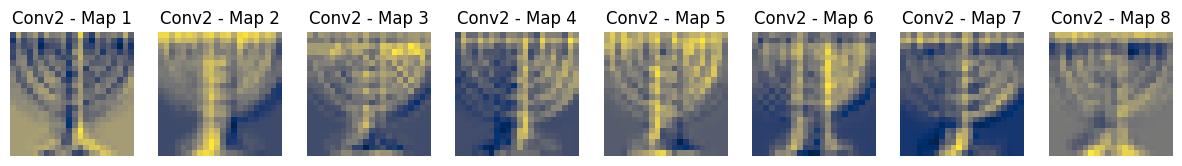

In [30]:
plot_feature_maps(image, outputs['conv2'], 'Conv2', num_maps=8)

In [31]:
# plot_feature_maps(image, outputs['conv3'], 'Conv3', num_maps=4)

# **Consider one image from the training set of each of the classes. Pass each image to CNN with the best architecture. Find out a neuron in the last convolutional layer (for each image) that is maximally activated**

Feature Maps for each image with Max Activation



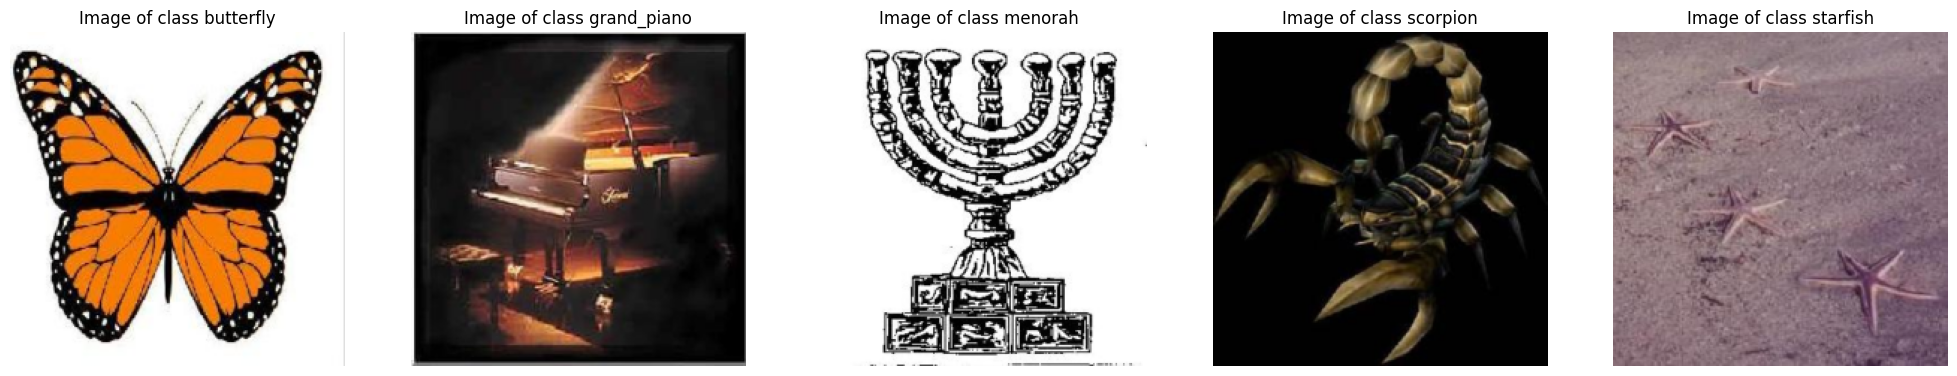

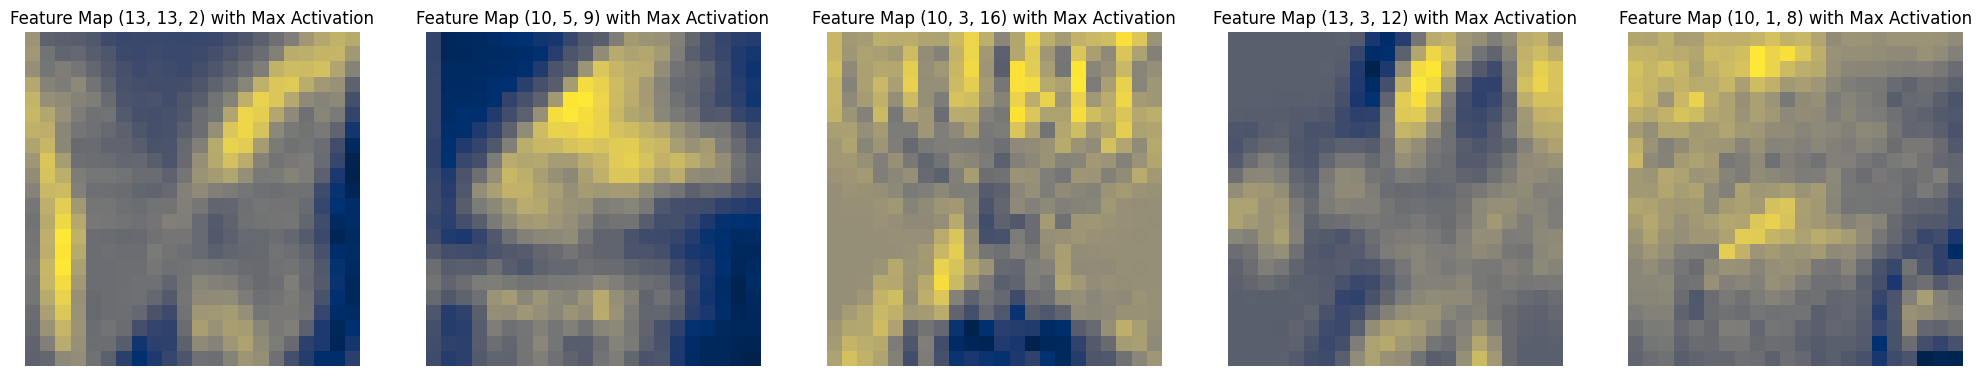

In [32]:
def find_maximally_activated_neuron(model, image_tensor):
    outputs, layer_info = output_per_layer(model, image_tensor)
    last_conv_layer_output = outputs['conv'+str(model.num_layers-2)]
    max_activation_map_index = np.unravel_index(np.argmax(last_conv_layer_output[0]), last_conv_layer_output[0].shape)
    max_activation_value = np.max(last_conv_layer_output[0])
    return max_activation_map_index, max_activation_value, last_conv_layer_output

# Load and preprocess the imagei
image1 = Image.open('/content/drive/MyDrive/train/butterfly/image_0001.jpg').convert('RGB')
image1_tensor = transform(image1).unsqueeze(0)  # Add batch dimension
image2 = Image.open('/content/drive/MyDrive/train/grand_piano/image_0001.jpg').convert('RGB')
image2_tensor = transform(image2).unsqueeze(0)  # Add batch dimension
image3 = Image.open('/content/drive/MyDrive/train/menorah/image_0004.jpg').convert('RGB')
image3_tensor = transform(image3).unsqueeze(0)  # Add batch dimension
image4 = Image.open('/content/drive/MyDrive/train/scorpion/image_0003.jpg').convert('RGB')
image4_tensor = transform(image4).unsqueeze(0)  # Add batch dimension
image5 = Image.open('/content/drive/MyDrive/train/starfish/image_0002.jpg').convert('RGB')
image5_tensor = transform(image5).unsqueeze(0)  # Add batch dimension

images_per_class = {'butterfly': image1_tensor,
                   'grand_piano': image2_tensor,
                   'menorah': image3_tensor,
                   'scorpion': image4_tensor,
                   'starfish': image5_tensor}

print("Feature Maps for each image with Max Activation\n")
# Iterate through the images and find the maximally activated neuron feature map
i=0
fig, axes1 = plt.subplots(1, 5, figsize=(25, 25))
fig, axes2 = plt.subplots(1, 5, figsize=(25, 25))
for class_name, image_tensor in images_per_class.items():
    # Display the image with the patch corresponding to the maximally activated neuron
    # image_tensor = torch.clamp(image_tensor, min=0.0, max=1.0)
    axes1[i].imshow(image_tensor.squeeze().permute(1, 2, 0).cpu().numpy(), cmap='cividis')
    axes1[i].set_title(f'Image of class {class_name}')
    axes1[i].axis('off')

    # Display the feature map with maximum activation
    max_activation_index, max_activation_value, conv_output = find_maximally_activated_neuron(best_architecture, image_tensor)
    axes2[i].imshow(conv_output[0, max_activation_index[0]], cmap='cividis')
    axes2[i].set_title(f'Feature Map {max_activation_index} with Max Activation')
    axes2[i].axis('off')
    i = i+1


# **Trace back to the patch in the image which causes these neurons to fire. Visualize the patches in each of the images which maximally activate that neuron.**

In [33]:
def compute_receptive_field(layer_info, max_activation_index, input_size=224):
    x, y = max_activation_index[1], max_activation_index[2]  # (channel, height, width)
    field_size_x, field_size_y = 1, 1
    layer_names = list(layer_info.keys())

    # Trace back the receptive field from this layer to the input
    for name in reversed(layer_names[:-1]):
        layer_params = layer_info[name]
        kernel_size = layer_params['kernel_size']
        stride = layer_params['stride']
        if 'maxpool' in name:
            x = x * stride + (kernel_size - 1) // 2
            y = y * stride + (kernel_size - 1) // 2
            field_size_x = field_size_x * stride + (kernel_size - stride)
            field_size_y = field_size_y * stride + (kernel_size - stride)

        else:
            x = (x * stride[0]) + (kernel_size[0] - 1) // 2
            y = (y * stride[1]) + (kernel_size[1] - 1) // 2
            field_size_x = field_size_x * stride[0] + (kernel_size[0] - stride[0])
            field_size_y = field_size_y * stride[1] + (kernel_size[1] - stride[1])

        x = np.clip(x, 0, input_size - 1)
        y = np.clip(y, 0, input_size - 1)
        field_size_x = np.clip(field_size_x, 0, input_size)
        field_size_y = np.clip(field_size_y, 0, input_size)

    rec_field_size = [field_size_x, field_size_y]
    return x, y, rec_field_size


def extract_receptive_field(image_tensor, receptive_field_size, receptive_field_position):
    # Convert tensor to numpy array
    image_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    # Calculate the cropping box
    rf_x, rf_y = receptive_field_size[0], receptive_field_size[1]
    rf_x_pos, rf_y_pos = receptive_field_position[0], receptive_field_position[1]
   # Ensure the coordinates are within the image dimensions
    left = max(rf_x_pos - rf_x // 2, 0)
    upper = max(rf_y_pos - rf_y // 2, 0)
    right = min(rf_x_pos + rf_x // 2, image_np.shape[1])
    lower = min(rf_y_pos + rf_y // 2, image_np.shape[0])
    # Crop the receptive field from the original image
    receptive_field = image_np[upper:lower, left:right, :]

    return receptive_field

Image Patches that maximally activate the neuron.



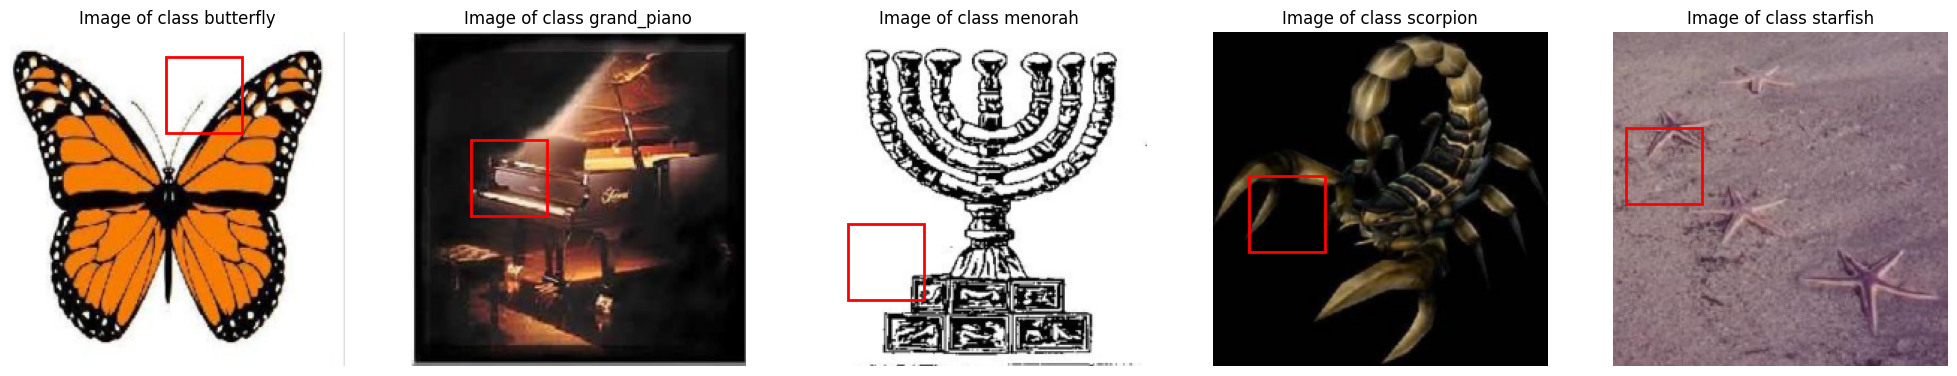

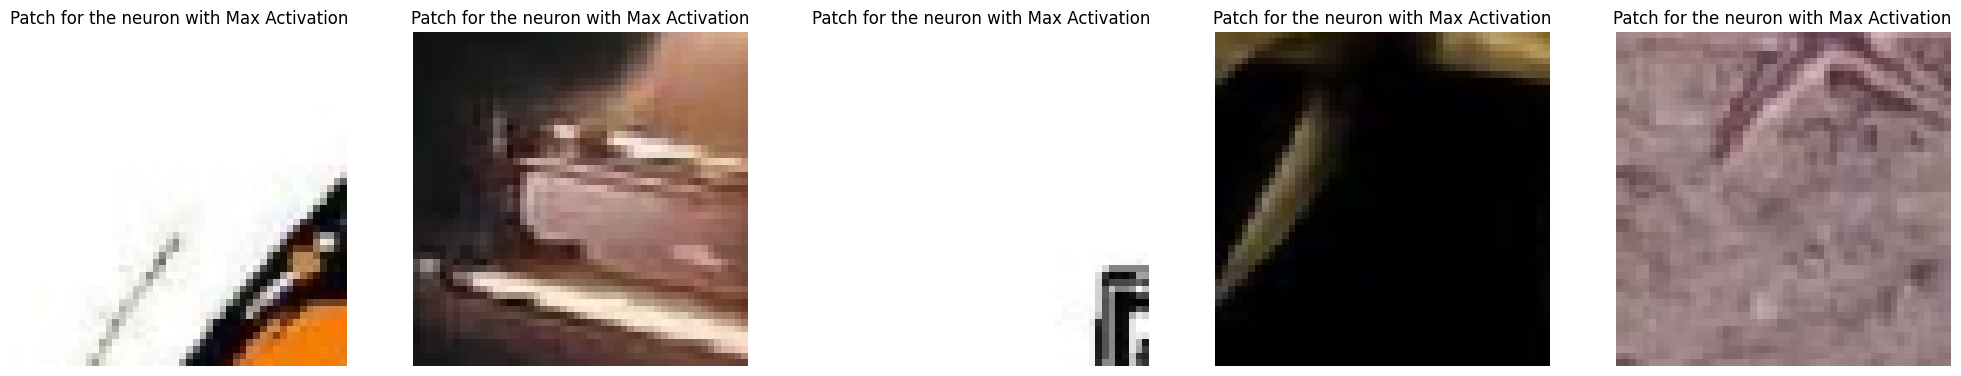

In [34]:
import matplotlib.patches as patches
# Visualize the receptive field on the input image
def visualize_receptive_field(images_per_class):
    print("Image Patches that maximally activate the neuron.\n")

    # Iterate through the images and find the patch corresponding to the maximally activated neuron
    i=0
    fig, axes1 = plt.subplots(1, 5, figsize=(25, 25))
    fig, axes2 = plt.subplots(1, 5, figsize=(25, 25))
    for class_name, image_tensor in images_per_class.items():
        # Display the image with the patch corresponding to the maximally activated neuron
        # image_tensor = torch.clamp(image_tensor, min=0.0, max=1.0)
        axes1[i].imshow(image_tensor.squeeze().permute(1, 2, 0).cpu().numpy(), cmap='cividis')
        axes1[i].set_title(f'Image of class {class_name}')
        axes1[i].axis('off')

        max_activation_index, max_activation_value, conv_output = find_maximally_activated_neuron(best_architecture, image_tensor)
        _, layer_info = output_per_layer(best_architecture, image_tensor)

        # Compute the receptive field
        receptive_field_x, receptive_field_y, receptive_field_size = compute_receptive_field(layer_info, max_activation_index)
        rect = patches.Rectangle(
            (receptive_field_x - receptive_field_size[1] // 2, receptive_field_y - receptive_field_size[0] // 2),
            receptive_field_size[1],
            receptive_field_size[0],
            edgecolor='red',
            facecolor='none',
            linewidth=2)

        axes1[i].add_patch(rect)

        receptive_field = extract_receptive_field(image_tensor, receptive_field_size, [receptive_field_x, receptive_field_y])
        axes2[i].imshow(receptive_field, cmap='cividis')
        axes2[i].set_title(f'Patch for the neuron with Max Activation')
        axes2[i].axis('off')
        i = i+1

visualize_receptive_field(images_per_class)
